# Fitness Trends Dataset A dataset of fitness trends and how they change with exercise

## Parte 2: Selección de Modelos

[Fitness Trends Dataset A dataset of fitness trends and how they change with exercise](https://www.kaggle.com/aroojanwarkhan/fitness-data-trends/)

Clases para el STAN de [Liricus SRL](http://www.liricus.com.ar)

Dictado durante 3 clases en el primer semestre del 2019 por personal del [IATE-OAC-CONICET](http://iate.oac.uncor.edu/)

## Librerias a usar

In [1]:
# contador
from collections import Counter

# computo numerico convencional
import numpy as np

# dataframes
import pandas as pd

# importamos plots
%matplotlib inline
import matplotlib.pyplot as plt

# mejor manejo de dataframes para plot
import seaborn as sns

# scikit learn
from sklearn import preprocessing

# fijamos el estado de random
np.random.seed(42)

# apagamos warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
Xc = ["step_count", "mood", "calories_burned", "hours_of_sleep", "weight_kg"]
yc = "bool_of_active"

In [3]:
df = pd.read_csv("data/fitness-data-trends.csv")

df["bool_of_active"] = df.bool_of_active.apply(lambda x: 1 if x else 0)

df = df.assign(date=pd.to_datetime(df.date))
df = df.set_index("date")

In [4]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df[Xc].values)
df[Xc] = x_scaled

In [5]:
df[Xc].describe()

,step_count,mood,calories_burned,hours_of_sleep,weight_kg
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.393529,0.557292,0.384559,0.459821,0.140625
std,0.289764,0.422211,0.294658,0.216607,0.313748
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.096796,0.000000,0.089506,0.285714,0.000000
50%,0.400500,0.500000,0.395062,0.428571,0.000000
75%,0.611228,1.000000,0.614198,0.571429,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


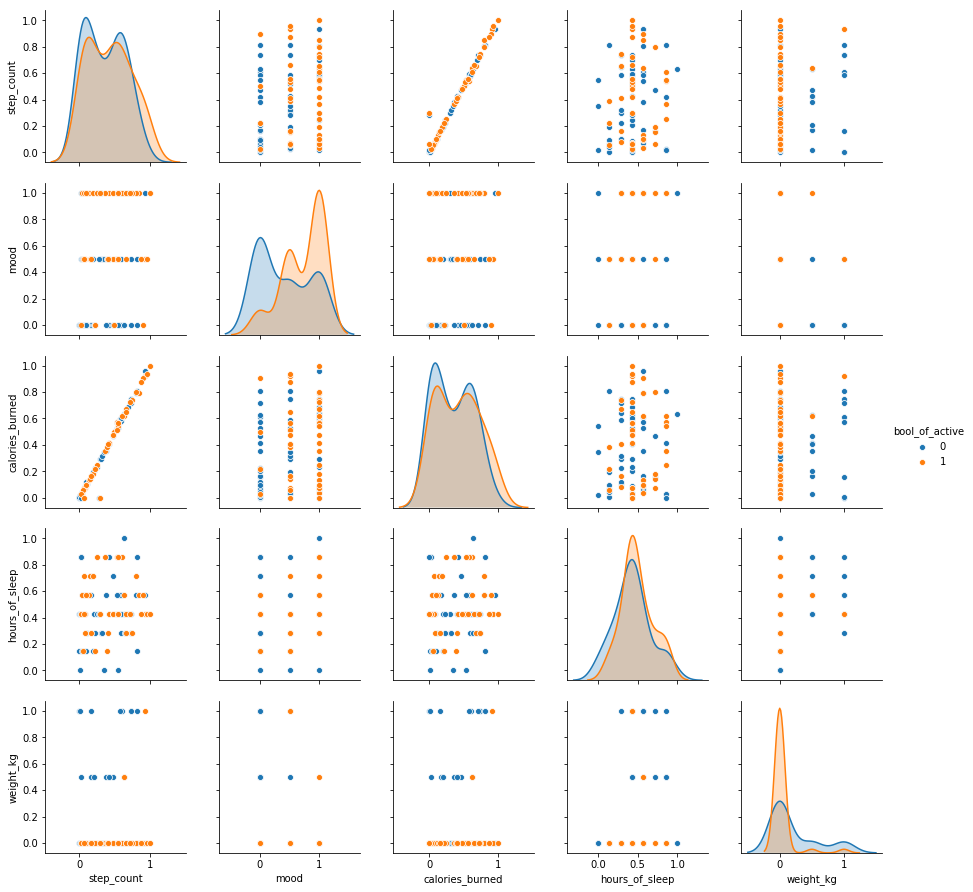

In [6]:
sns.pairplot(df, hue=yc, vars=Xc);

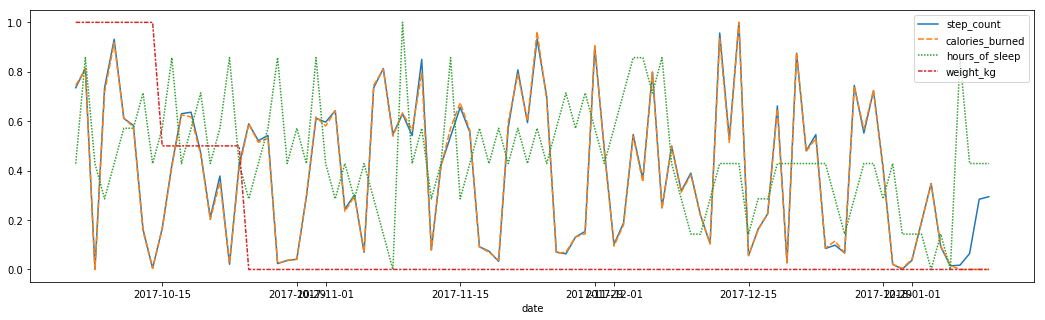

In [7]:
fig, ax = plt.subplots(figsize=(18, 5))
sns.lineplot(data=df[["step_count", "calories_burned", "hours_of_sleep", "weight_kg"]], ax=ax)

## Repasando Machine Learning

<b><a href="imgs/slides.pdf">![ddd](imgs/err1.png)</a></b>

### Hyper Parámetros

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import joblib

In [9]:
cpu = joblib.cpu_count()
print(cpu)

8


In [10]:
X = df[Xc].values
y = df[yc].values

bests = {}

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

### Suport Vector Machines

In [11]:
from sklearn.svm import SVC

In [12]:
%%time

# Set the parameters by cross-validation
tuned_parameters = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5, n_jobs=cpu,
                       scoring='%s_macro' % score)
    
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    
    # store the bests
    clf_name = clf.estimator.__class__.__name__
    if clf_name not in bests:
        bests[clf_name] = {}
    bests[clf_name][score] = clf.best_params_

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.74      0.78      0.76        18
           1       0.60      0.55      0.57        11

    accuracy                           0.69        29
   macro avg       0.67      0.66      0.66        29
weighted avg       0.68      0.69      0.69        29


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.74      0.78      0.76        18
           1       0.60      0.55      0.57        11

   

### Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
%%time

# Set the parameters by cross-validation
tuned_parameters = [
    {'max_features': ['auto', 'sqrt', "log2", None, 0.2, 0.5], 
     "min_samples_split": [2, 5, 10],
     "n_estimators": [500], 
     "criterion": ["entropy"], 
     "n_jobs": [10]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, n_jobs=cpu,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    
    # store the bests
    clf_name = clf.estimator.__class__.__name__
    if clf_name not in bests:
        bests[clf_name] = {}
    bests[clf_name][score] = clf.best_params_

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'criterion': 'entropy', 'max_features': 0.2, 'min_samples_split': 10, 'n_estimators': 500, 'n_jobs': 10}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.73      0.89      0.80        18
           1       0.71      0.45      0.56        11

    accuracy                           0.72        29
   macro avg       0.72      0.67      0.68        29
weighted avg       0.72      0.72      0.71        29


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'criterion': 'entropy', 'max_features': 0.2, 'min_samples_split': 10, 'n_estimators': 500, 'n_jobs': 10}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             

### K-Nearest NeightBorgs

In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [16]:
%%time

# Set the parameters by cross-validation
tuned_parameters = [
    {'n_neighbors': range(3, 30), 
     "weights": ["uniform", "distance"],
     "p": [1, 2]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, n_jobs=cpu,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    
    # store the bests
    clf_name = clf.estimator.__class__.__name__
    if clf_name not in bests:
        bests[clf_name] = {}
    bests[clf_name][score] = clf.best_params_

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_neighbors': 27, 'p': 2, 'weights': 'uniform'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.71      0.83      0.77        18
           1       0.62      0.45      0.53        11

    accuracy                           0.69        29
   macro avg       0.67      0.64      0.65        29
weighted avg       0.68      0.69      0.68        29


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'n_neighbors': 27, 'p': 2, 'weights': 'uniform'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.71      0.83      0.77        18
           1    

### Comparando los mejores

In [17]:
from IPython.display import display, Markdown

In [18]:
out = []
for clf, results in bests.items():
    out.append(f"#### {clf}")
    for score, best in results.items():
        out.append(f"- **{score}**: {best}")
    out.append("")

display(Markdown("\n".join(out)))

#### SVC
- **precision**: {'C': 1, 'kernel': 'linear'}
- **recall**: {'C': 1, 'kernel': 'linear'}

#### RandomForestClassifier
- **precision**: {'criterion': 'entropy', 'max_features': 0.2, 'min_samples_split': 10, 'n_estimators': 500, 'n_jobs': 10}
- **recall**: {'criterion': 'entropy', 'max_features': 0.2, 'min_samples_split': 10, 'n_estimators': 500, 'n_jobs': 10}

#### KNeighborsClassifier
- **precision**: {'n_neighbors': 27, 'p': 2, 'weights': 'uniform'}
- **recall**: {'n_neighbors': 27, 'p': 2, 'weights': 'uniform'}


### Persistiendo

In [19]:
import pickle

In [20]:
with open("out/scaler.pkl", "wb") as fp:
    pickle.dump(min_max_scaler, fp)

df.to_pickle("out/scaled_df.pkl")

with open("out/best_results.pkl", "wb") as fp:
    pickle.dump(bests, fp)